_This notebook contains code and comments from Section 9.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

___

## Estudio de caso: marketing basado en datos
El conjunto de datos de marketing bancario se extrae del [del repositorio de UCI](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). La descripción y los detalles del conjunto de datos a continuación provienen directamente de la documentación del conjunto de datos.

**Descripción**: Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente, para poder acceder si el producto (depósito bancario a plazo) estaría ('sí') o no ('no') suscrito. El objetivo de la clasificación es predecir si el cliente suscribirá (sí/no) un depósito a plazo (variable y).

Hay cuatro conjuntos de datos; Usaremos ``bank-additional-full.csv`` con todos los ejemplos (41188) y 20 entradas, ordenadas por fecha (de mayo de 2008 a noviembre de 2010), muy cerca de los datos analizados en [Moro et al., 2014].

### Variables de entrada:

#### datos del cliente bancario:
1. ``age`` (numeric)
2. ``job``: tipo de empleo (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
3. ``marital``: estado civil (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
4. ``education`` (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
5. ``default``: ¿tiene credito en mora? (categorical: 'no','yes','unknown')
6. ``housing``: ¿tiene préstamo de vivienda? (categorical: 'no','yes','unknown')
7. ``loan``: ¿tiene préstamo personal? (categorical: 'no','yes','unknown')

#### relacionados con el último contacto de la campaña actual:
8. ``contact``: tipo de contacto (categorical: 'cellular','telephone')
9. ``month``: mes del último contacto (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. ``day_of_week``: día del último contacto (categorical: 'mon','tue','wed','thu','fri')
11. ``duration``: duración del último contacto, en segundos (numérico). _Nota importante: este atributo afecta mucho el objetivo de salida (ej., si duration=0 entonces y='no'). Sin embargo, la duración no se conoce antes de que se realice una llamada. Además, después del final de la llamada y es obviamente conocido. Por lo tanto, esta entrada solo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista._

#### otros atributos:
12. ``campaign``: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye último contacto)
13. ``pdays``: número de días transcurridos desde la última vez que se contactó al cliente de una campaña anterior (numérico; 999 significa que no se contactó al cliente previamente)
14. ``previous``: número de contactos realizados antes de esta campaña y para este cliente (numeric)
15. ``poutcome``: resultado de la campaña de marketing anterior (categorical: 'failure','nonexistent','success')

#### atributos del contexto social y económico:
16. ``emp.var.rate``: tasa de variación del empleo - indicador trimestral (numeric)
17. ``cons.price.idx``: índice de precios al consumidor - indicador mensual (numeric)
18. ``cons.conf.idx``: índice de confianza del consumidor - indicador mensual (numeric)
19. ``euribor3m``: euribor 3 meses tasa - indicador diario (numeric). _El Euro Interbank Offered Rate (Euribor) es un tipo de referencia diario, publicado por el European Money Markets Institute._
20. ``nr.employed``: número de empleados - indicador trimestral (numeric)

#### Variable de salida:
21. ``y`` - ¿el cliente ha suscrito un depósito a plazo? (binary: 'yes','no')

In [2]:
# General imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
# Load data set
data_file = './data/ch09/bank-additional-full.csv'
df = pd.read_csv(data_file, sep=';')

# Drop 'duration' column as it is essentially another output variable
df = df.drop('duration', axis=1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


El siguiente código carga el conjunto de datos, lo divide en conjuntos de entrenamiento y prueba y los procesa previamente. Las funciones continuas se escalan entre 0 y 1 utilizando ``MinMaxEncoder`` de scikit-learn y las funciones categóricas se codifican con ``OrdinalEncoder``.

**Apartado 9.3.** Cargar y preprocesar el Bank Marketing Data Set

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataframe into features and labels
y = df['y']
X = df.drop('y', axis=1)

# Split into train and test with stratified sampling to preserve class balances
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, stratify=y, test_size=0.25) 

In [5]:
# Preprocess the labels
from sklearn.preprocessing import LabelEncoder

preprocess_labels = LabelEncoder()
ytrn = preprocess_labels.fit_transform(ytrn).astype(float)
ytst = preprocess_labels.transform(ytst)

In [6]:
# Preprocess the features
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_features = ['default', 'housing', 'loan', 'contact', 'poutcome', 
                'job', 'marital', 'education', 'month', 'day_of_week']
cntnous_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                    'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'euribor3m']

preprocess_categorical = Pipeline(steps=[('encoder', OrdinalEncoder())])
preprocess_numerical = Pipeline(steps=[('scaler', MinMaxScaler())])
data_transformer = ColumnTransformer(transformers=[('categorical', preprocess_categorical, cat_features),
                                                   ('numerical', preprocess_numerical, cntnous_features)])
all_features = cat_features + cntnous_features

Xtrn = pd.DataFrame(data_transformer.fit_transform(Xtrn), columns=all_features)
Xtst = pd.DataFrame(data_transformer.transform(Xtst), columns=all_features)

In [7]:
# Save the pre-processed data
data = {}
data['Xtrn'] = Xtrn
data['Xtst'] = Xtst
data['ytrn'] = ytrn
data['ytst'] = ytst

with open('./data/ch09/bank_marketing_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
### Modelado con XGBoost
El siguiente código muestra cómo podemos entrenar un conjunto XGBoost sobre este conjunto de datos. Utilizamos la búsqueda aleatoria en cuadrícula combinada con la validación cruzada de 5 veces y la detención anticipada para seleccionar entre varios hiperparámetros, como la tasa de aprendizaje y los parámetros de regularización.

**Apartado 9.3.** Entrenamiento de XGBoost en el conjunto de datos de marketing del banco

In [8]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {'learning_rate': [0.001, 0.01, 0.1],  # Learning rate  
              'n_estimators': [100],                # Maximum number of trees
              'max_depth': [3, 5, 7, 9],            # Maximum tree depth     
              'lambda': [0.001, 0.01, 0.1, 1],      # L2 regularization
              'alpha': [0, 0.001, 0.01, 0.1],       # L1 regularization 
              'subsample': [0.6, 0.7, 0.8, 0.9],    # Fraction of rows to sample
              'colsample_bytree': [0.5, 0.6, 0.7],  # Fraction of columns to sample
              'scale_pos_weight': [5, 10, 50, 100]  # Weight on postive examples (imbalanced data set)
             }

fit_params = {'eval_set': [(Xtst, ytst)],
              'verbose': 0
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', use_label_encoder=False, early_stopping_rounds=15) 
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, n_iter=40, verbose=2, n_jobs=-1)
xgb_search.fit(X=Xtrn, y=ytrn.ravel(), **fit_params)

c:\Users\lasm1\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\lasm1\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\lasm1\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=15,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.001, 0.01, 0.1],
                                        'colsample_bytree': [0.5, 0.6, 0.7],
                                        'lambda': [0.001, 0.01, 0.1, 1],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100],
                                        'scale_pos_weight': [5, 10, 50, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   verbose=2)

In [9]:
xgb_search.best_score_

0.8685698659464951

In [10]:
xgb_search.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 5,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.1,
 'lambda': 0.001,
 'colsample_bytree': 0.6,
 'alpha': 0.001}

<BarContainer object of 19 artists>

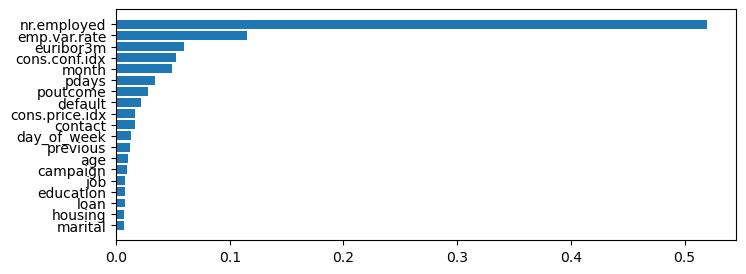

In [11]:
# Each XGBoost ensemble has its own feature importances
scores = xgb_search.best_estimator_.feature_importances_
features = Xtrn.columns.to_numpy()
srtd = np.argsort(scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.barh(y=features[srtd], width=scores[srtd])

---
### Modelado con Random Forests
El siguiente código muestra cómo podemos entrenar un conjunto de bosques aleatorios sobre este conjunto de datos

**Apartado 9.4.** Entrenando un bosque aleatorio sobre el conjunto de datos de marketing del banco

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {'max_depth': [3, 5, 7],                # Maximum tree depth     
             'max_samples': [0.5, 0.6, 0.7, 0.8],   # Fraction of rows to sample
             'max_features': [0.5, 0.6, 0.7, 0.8],  # Fraction of columns to sample
             }

rf = RandomForestClassifier(class_weight={0: 1, 1: 10}, n_estimators=100) 
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=30, verbose=2, n_jobs=-1)
rf_search.fit(X=Xtrn, y=ytrn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 1, 1: 10}),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'max_features': [0.5, 0.6, 0.7, 0.8],
                                        'max_samples': [0.5, 0.6, 0.7, 0.8]},
                   verbose=2)

In [13]:
rf_search.best_score_

0.8328636384759813

In [14]:
rf_search.best_params_

{'max_samples': 0.5, 'max_features': 0.7, 'max_depth': 7}

<BarContainer object of 19 artists>

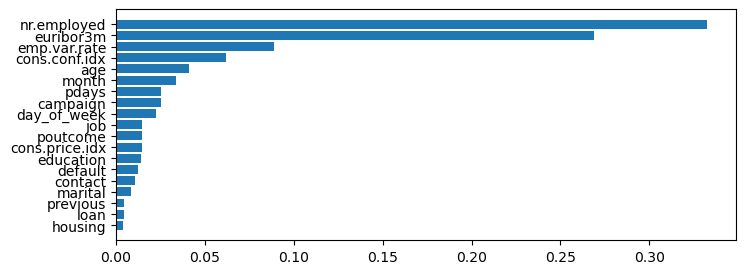

In [15]:
# Each random ensemble has its own feature importances
scores = rf_search.best_estimator_.feature_importances_
features = Xtrn.columns.to_numpy()
srtd = np.argsort(scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.barh(y=features[srtd], width=scores[srtd])

In [16]:
# Save the trained models as a pickle file
models = {'xgb': xgb_search.best_estimator_,
          'rf': rf_search.best_estimator_}

with open('./data/ch09/bank_marketing_models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Load the trained models for visualization of feature importances
import pickle

with open('./data/ch09/bank_marketing_models.pickle', 'rb') as handle:
    models = pickle.load(handle)
print(models)

{'xgb': XGBClassifier(alpha=0.001, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=15,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.001, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...), 'rf': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=7,
                       max_features=0.7, max_samples=0.5)}


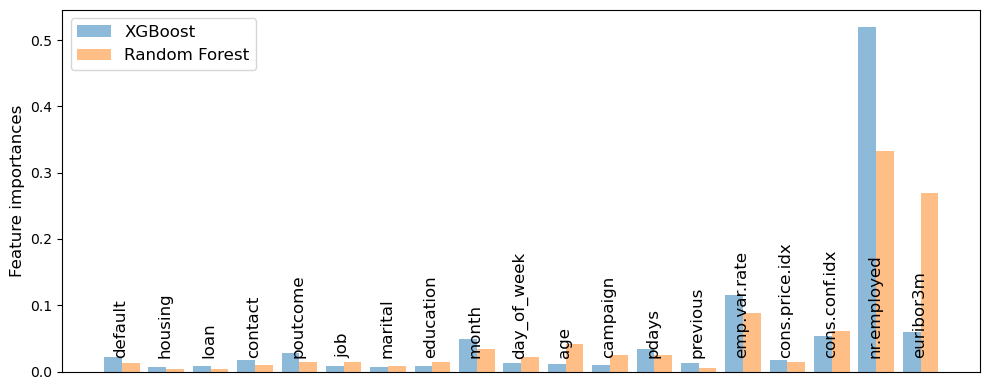

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

scores = np.column_stack([models['xgb'].feature_importances_,
                          models['rf'].feature_importances_])
features = Xtrn.columns.to_numpy()
# ax.bar(x=features, height=scores)
ax.bar(x=np.arange(0, len(features)) - 0.2, width=0.4, height=models['xgb'].feature_importances_, alpha=0.5)
ax.bar(x=np.arange(0, len(features)) + 0.2, width=0.4, height=models['rf'].feature_importances_, alpha=0.5)
for i, f in enumerate(features):
    ax.text(i-0.2, 0.025, f, rotation=90, fontsize=12)
ax.legend(['XGBoost', 'Random Forest'], fontsize=12)
ax.set_ylabel('Feature importances', fontsize=12)
ax.set_xticks([]);

fig.tight_layout()
# plt.savefig('./figures/CH09_F06_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
# plt.savefig('./figures/CH09_F06_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')